<a href="https://colab.research.google.com/github/fabioFernandesBR/CorrosionDetection/blob/main/MVP_CorrosionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PUC Rio - Specialization in Data Science and Analytics**

*MVP - Machine Learning and Analytics*

*by Fábio Fernandes*

# **Assessing the application of Convolutional Neural Network to detect corrosion in pipelines from ultrasonic inspection data**

**Context:**
Pipelines that transport various fluids (oil, gas, refined products, slurry, water) are threatened in different ways, being corrosion of the most important. A common way to detect and measure the corrosion in a pipeline is *pigging*, which consists in running a tool equipped with sensors inside the pipeline throughout its length. Ultrassonic (UT) sensors are widely used for this purpose.

**Problem:**
Depending on the pipeline length and the internal condition of the pipeline, among other variables, detecting and measuring corrosion can be very time consuming and subject to human errors.

**Purpose of this study:**
We will assess the application of few Convolutional Neural Networks (CNN) to identify the boxes of corrosions in the images generated by the UT.

**Approach:**

0- Set up the notebook.

1- Organize some data for training and validation. Training will use patches (small samples of images) and validation will use complete images, annotated by humans to set the "ground truth".

2- Create, train and test 1 CNN. Check the results and set the baseline.

3- Create, train and test additional few CNN, changing parameters in the design of CNN. Check the results.

4- Compare the results against the baseline.

5- Draw conclusions and lessons learnt.

This work is published in my github repository: https://github.com/fabioFernandesBR/CorrosionDetection

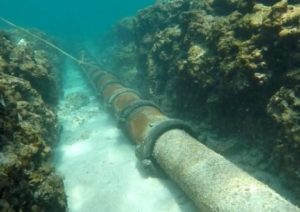
*corroded subsea pipeline*

# 0 - Notebook setup

In [1]:
# Importing Python Libraries

## Built-in
import os
import random
import shutil
import zipfile
from io import BytesIO

## Third-party
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array


In [2]:
# Setting seeds for reprodutibility even with randomness

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
# Cloning github repository to get the needed images
!git clone https://github.com/fabioFernandesBR/CorrosionDetection.git
base_path = "CorrosionDetection/Screenshots UTWM"

fatal: destination path 'CorrosionDetection' already exists and is not an empty directory.


### Defining all the functions that will be needed


In [4]:
# Function to read images
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV reads BGR
    return img

In [5]:
### Creating the function to change patches size to the standard:
def process_patches(src_folder, dst_folder, label):
    count = 0
    for fname in os.listdir(src_folder):
        fpath = os.path.join(src_folder, fname)
        img = cv2.imread(fpath)
        if img is None:
            print(f"⚠️ I couldn't load {fpath}")
            continue
        # resizes
        img = cv2.resize(img, IMG_SIZE)
        # renames using standard
        new_name = f"{label}_{count}.png"
        save_path = os.path.join(dst_folder, new_name)
        cv2.imwrite(save_path, img)
        count += 1
    print(f"✅ {count} {label} processed patches")

In [6]:
### Instantiating the image generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [7]:
### Creating the data augmentation function
def augment_and_save(class_dir, target_dir, n_aug, seed):
    """
    Performs data augmentation on all images from class_dir and saves them in target_dir.
    Keeps track of both original and generated image counts.

    Args:
    class_dir: folder with original images (corrosion or non_corrosion)
    target_dir: folder where augmented images will be saved
    n_aug: number of augmented images to generate per original image
    seed: random seed value for reproducibility
    """
    if os.path.exists(target_dir):
      shutil.rmtree(target_dir)  # deletes folder

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    original_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

    total_generated = 0

    for fname in original_files:
        img_path = os.path.join(class_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))  # standard size
        x = np.expand_dims(img, axis=0)

        gen = datagen.flow(x, batch_size=1, seed=seed)

        base = os.path.splitext(fname)[0]
        for i in range(n_aug):
            aug_img = next(gen)[0].astype(np.uint8)
            aug_name = f"{base}_aug{i}.png"
            cv2.imwrite(os.path.join(target_dir, aug_name), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            total_generated += 1

    # ✅ counting
    orig_count = len(original_files)
    aug_count = len([f for f in os.listdir(target_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    print(f"📊 {class_dir}: {orig_count} originals, {aug_count} augmented ({total_generated} created now)")

In [8]:
def read_random_images(folder, n=3):
    """Selects n random images from a folder and returns them as a list of RGB arrays."""
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    sample = random.sample(files, min(n, len(files)))  # garante que não passa do limite
    imgs = []
    for f in sample:
        img = cv2.imread(os.path.join(folder, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

In [9]:
### Split files into train/val and copy them.
def split_and_copy(src_dir, train_dir, val_dir, test_size, seed=SEED):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_files, val_files = train_test_split(files, test_size=test_size, random_state=seed)

    # copy train files
    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dir, f))
    # copy val files
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(val_dir, f))

    print(f"📊 {src_dir}: {len(train_files)} train, {len(val_files)} val")

In [10]:
### Function Evaluate Slidding Window - function to evaluate how good or bad the CNN detects corrosion in images, in comparison to a manually annotated images.

def evaluate_sliding_window(
    model,
    validation_dir,
    annotations_dir,
    patch_size=(128,128),
    stride=32,
    threshold=0.5,
    batch_size=32,
    plot=False,
    max_plot_images=5
):
    """
    Sliding window evaluation using Numpy strided patches + batch prediction.
    IoU computed between aggregated box (yellow) and ground truth (black).
    """
    import numpy as np
    import cv2
    import os
    from tensorflow.keras.utils import img_to_array
    import matplotlib.pyplot as plt
    from numpy.lib.stride_tricks import as_strided

    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interW = max(0, xB - xA)
        interH = max(0, yB - yA)
        interArea = interW * interH
        boxAArea = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
        boxBArea = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
        return interArea / float(boxAArea + boxBArea - interArea + 1e-8)

    def extract_patches(img, patch_size=(128,128), stride=32):
        H, W, C = img.shape
        ph, pw = patch_size
        nH = (H - ph) // stride + 1
        nW = (W - pw) // stride + 1
        shape = (nH, nW, ph, pw, C)
        strides = (
            img.strides[0]*stride,
            img.strides[1]*stride,
            img.strides[0],
            img.strides[1],
            img.strides[2]
        )
        patches = as_strided(img, shape=shape, strides=strides)
        coords = [
            (x*stride, y*stride, x*stride+pw, y*stride+ph)
            for y in range(nH) for x in range(nW)
        ]
        return patches.reshape(-1, ph, pw, C), coords

    all_results = []
    per_image = {}
    plot_count = 0

    for fname in os.listdir(validation_dir):
        img_path = os.path.join(validation_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W, _ = img.shape

        # Load ground truth boxes
        txt_path = os.path.join(annotations_dir, os.path.splitext(fname)[0]+".txt")
        gt_boxes = []
        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                for line in f:
                    class_id, xc, yc, w_box, h_box = map(float, line.strip().split())
                    x1 = int((xc - w_box/2) * W)
                    y1 = int((yc - h_box/2) * H)
                    x2 = int((xc + w_box/2) * W)
                    y2 = int((yc + h_box/2) * H)
                    gt_boxes.append((x1, y1, x2, y2))

        # --- Extract patches with Numpy
        patches, coords = extract_patches(img, patch_size=patch_size, stride=stride)
        patches = patches.astype(np.float32)/255.0

        # --- Predict in batches
        detections = []
        for i in range(0, len(patches), batch_size):
            batch_patches = patches[i:i+batch_size]
            batch_coords = coords[i:i+batch_size]
            preds = model.predict(batch_patches, batch_size=batch_size, verbose=0).flatten()
            for coord, p in zip(batch_coords, preds):
                if p >= threshold:
                    detections.append((coord[0], coord[1], coord[2], coord[3], p))

        # --- Aggregated box
        if detections:
            x_min = min([d[0] for d in detections])
            y_min = min([d[1] for d in detections])
            x_max = max([d[2] for d in detections])
            y_max = max([d[3] for d in detections])
            aggregated_box = (x_min, y_min, x_max, y_max)
        else:
            aggregated_box = None

        # --- IoU
        iou_values = []
        if aggregated_box:
            for gt in gt_boxes:
                iou_values.append(iou(aggregated_box, gt))
        mean_iou = np.mean(iou_values) if iou_values else 0.0
        min_iou = np.min(iou_values) if iou_values else 0.0
        max_iou = np.max(iou_values) if iou_values else 0.0

        per_image[fname] = {
            "mean_iou": mean_iou,
            "min_iou": min_iou,
            "max_iou": max_iou,
            "num_patches": len(detections)
        }
        all_results.append(mean_iou)

        # --- Optional plot
        if plot and plot_count < max_plot_images:
            img_copy = img.copy()
            for (x1, y1, x2, y2, p) in detections:
                cv2.rectangle(img_copy, (x1, y1), (x2, y2), (128,128,128), 2)
                cv2.putText(img_copy, f"{p:.2f}", (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (128,128,128), 1)
            if aggregated_box:
                cv2.rectangle(img_copy, (aggregated_box[0], aggregated_box[1]),
                              (aggregated_box[2], aggregated_box[3]), (255,255,0), 2)
            for (x1, y1, x2, y2) in gt_boxes:
                cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0,0,0), 2)
            plt.figure(figsize=(12,6))
            plt.imshow(img_copy)
            plt.axis('off')
            plt.show()
            plot_count += 1

    summary = {
        "mean_iou": np.mean(all_results),
        "per_image": per_image
    }
    return summary


In [11]:
### Function to create multiple CNNs automatically from a set of parameters (filters list and dropout)
def build_cnn(filters_list, dropout_rate=0.5, input_shape=(128,128,3)):
    """
    Build a CNN with a given list of filters and dropout rate.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))  # use Input layer to avoid Keras warning

    for filters in filters_list:
        model.add(Conv2D(filters, (3,3), activation='relu'))
        model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model




In [12]:
### The parameter below is pretty much the same we've used previously, just adding rescale and validation_split
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',

    rescale=1./255,
    validation_split=0.2
)
### Using this, we can create all the needed augmented images, online and on-the-fly, not being needed to store them on disk.
### Rescaling (dividing by 255) is to create a numerical range that will be consummed by the learning process.
### Since we are not going to plot the augmented patches, this is ok.

In [13]:
# ===============================
# Function to train a single CNN
# ===============================
def train_model(model, model_name, train_gen, val_gen, epochs=20):
    print(f"\n🎯 Training {model_name}...\n")
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        validation_steps=val_gen.samples // val_gen.batch_size
    )
    print(f"✅ Finished training {model_name}\n")
    return history

In [14]:
def plot_best_worst_iou(results_summary, cnn_models, validation_dir, annotations_dir, patch_size=(128,128), stride=32, threshold=0.5):
    import numpy as np
    import cv2
    import os
    import matplotlib.pyplot as plt
    from tensorflow.keras.utils import img_to_array

    # --- Step 1: Find best and worst IoU
    best_iou = -1
    worst_iou = 2
    best_pair = None
    worst_pair = None

    for model_name, summary in results_summary.items():
        for img_name, metrics in summary["per_image"].items():
            iou_val = metrics["mean_iou"]
            if iou_val > best_iou:
                best_iou = iou_val
                best_pair = (model_name, img_name)
            if iou_val < worst_iou:
                worst_iou = iou_val
                worst_pair = (model_name, img_name)

    print(f"Best IoU: {best_iou:.3f} -> Model: {best_pair[0]}, Image: {best_pair[1]}")
    print(f"Worst IoU: {worst_iou:.3f} -> Model: {worst_pair[0]}, Image: {worst_pair[1]}")

    def run_and_plot(model_name, img_name, title):
        model = cnn_models[model_name]
        img_path = os.path.join(validation_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W, _ = img.shape

        # Load GT boxes
        txt_path = os.path.join(annotations_dir, os.path.splitext(img_name)[0]+".txt")
        gt_boxes = []
        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                for line in f:
                    class_id, xc, yc, w_box, h_box = map(float, line.strip().split())
                    x1 = int((xc - w_box/2) * W)
                    y1 = int((yc - h_box/2) * H)
                    x2 = int((xc + w_box/2) * W)
                    y2 = int((yc + h_box/2) * H)
                    gt_boxes.append((x1, y1, x2, y2))

        # Sliding window patch predictions
        detections = []
        for y in range(0, H - patch_size[1] + 1, stride):
            for x in range(0, W - patch_size[0] + 1, stride):
                patch = img[y:y+patch_size[1], x:x+patch_size[0]]
                patch_input = cv2.resize(patch, patch_size)
                patch_input = img_to_array(patch_input)/255.0
                patch_input = np.expand_dims(patch_input, axis=0)
                pred = model.predict(patch_input, verbose=0)[0][0]
                if pred >= threshold:
                    detections.append((x, y, x+patch_size[0], y+patch_size[1], pred))

        # Aggregated box
        if detections:
            x_min = min(d[0] for d in detections)
            y_min = min(d[1] for d in detections)
            x_max = max(d[2] for d in detections)
            y_max = max(d[3] for d in detections)
            aggregated_box = (x_min, y_min, x_max, y_max)
        else:
            aggregated_box = None

        # Plot
        img_copy = img.copy()
        for (x1, y1, x2, y2, p) in detections:
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (128,128,128), 2)
        if aggregated_box:
            cv2.rectangle(img_copy, (aggregated_box[0], aggregated_box[1]),
                          (aggregated_box[2], aggregated_box[3]), (255,255,0), 2)
        for (x1, y1, x2, y2) in gt_boxes:
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0,0,0), 2)

        plt.figure(figsize=(12,6))
        plt.imshow(img_copy)
        plt.title(f"{title} - {model_name} - {img_name}")
        plt.axis('off')
        plt.show()

    # --- Run for best and worst
    run_and_plot(*best_pair, title="Best IoU")
    run_and_plot(*worst_pair, title="Worst IoU")


# 1 - Image organization

## Visual exploration of patches for training and complete images

The original images and the patches (images segments, representatives of the classes corrosion and non-corrosion) have been moved from the GitHub repository to the Colab Notebook. Let's have a look on them.

In [15]:
# Defining images path
original_dir = "CorrosionDetection/Screenshots UTWM/Originais"
corrosion_dir = "CorrosionDetection/Screenshots UTWM/patches/Corrosion"
non_corrosion_dir = "CorrosionDetection/Screenshots UTWM/patches/Non Corrosion"

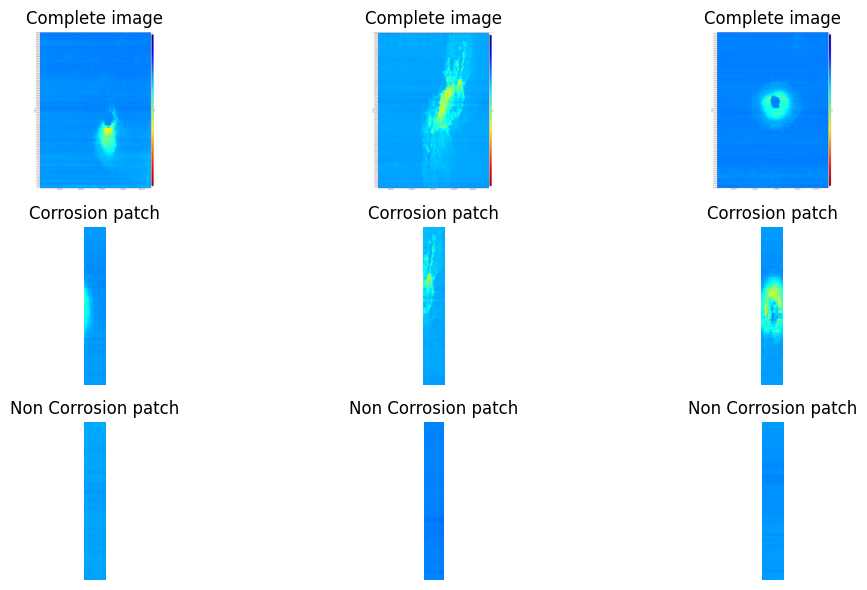

In [16]:
# Select 3 complete images
complete_imgs = [read_img(os.path.join(original_dir, f))
                  for f in os.listdir(original_dir)[:3]]

# Select 3 patches of each class (corrosion x non corrosion)
corrosion_imgs = [read_img(os.path.join(corrosion_dir, f))
                  for f in os.listdir(corrosion_dir)[:3]]
non_corrosion_imgs = [read_img(os.path.join(non_corrosion_dir, f))
                      for f in os.listdir(non_corrosion_dir)[:3]]

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(12, 6))
for i, img in enumerate(complete_imgs):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title("Complete image")

for i, img in enumerate(corrosion_imgs):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Corrosion patch")

for i, img in enumerate(non_corrosion_imgs):
    axes[2, i].imshow(img)
    axes[2, i].axis('off')
    axes[2, i].set_title("Non Corrosion patch")

plt.tight_layout()
plt.show()

## Standardizing patches size

In order to run properly in the Deep Learning algorithms, we will standardize the patches size to 128x128 pixels. Let's do this and see how they become.

In [17]:
### Standard patch size parameter
IMG_SIZE = (128, 128)

In [18]:
### Creating folders in Colab ==> These are the locations where the resized patches will be stored
os.makedirs("data/patches/originals/0_non_corrosion", exist_ok=True)
os.makedirs("data/patches/originals/1_corrosion", exist_ok=True)


In [19]:
### Running the function / Resizing patches
process_patches(os.path.join(base_path, "patches/Corrosion"), "data/patches/originals/1_corrosion", "corrosion")
process_patches(os.path.join(base_path, "patches/Non Corrosion"), "data/patches/originals/0_non_corrosion", "non_corrosion")


✅ 12 corrosion processed patches
✅ 11 non_corrosion processed patches


We have few patches, 23 in total, but the classes are balanced.

## Checking how the patches become after resizing

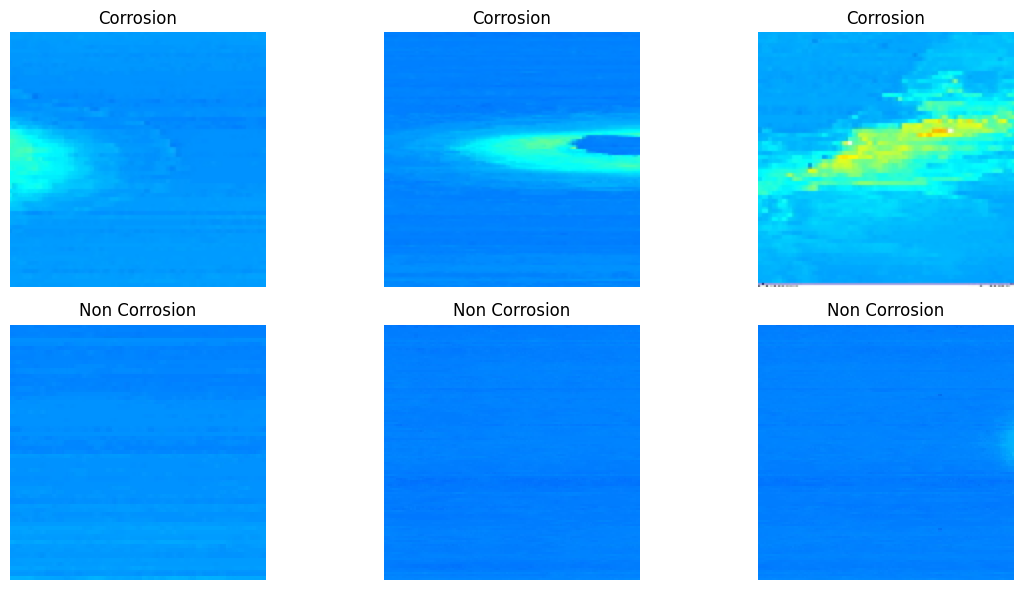

In [20]:
# Setting the path to read the patches
corrosion_dir = "data/patches/originals/1_corrosion"
non_corrosion_dir = "data/patches/originals/0_non_corrosion"

# Select 3 images of each class
corrosion_imgs = [read_img(os.path.join(corrosion_dir, f))
                  for f in os.listdir(corrosion_dir)[:3]]
non_corrosion_imgs = [read_img(os.path.join(non_corrosion_dir, f))
                      for f in os.listdir(non_corrosion_dir)[:3]]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, img in enumerate(corrosion_imgs):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title("Corrosion")

for i, img in enumerate(non_corrosion_imgs):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Non Corrosion")

plt.tight_layout()
plt.show()

Now we have standard size patches representing corroded and not corroded areas. **But we have just a few images.** We can workaround this, creating new images which are slight variations of the original ones. This process is called **Data Augmentation**. Let's apply it and see its results.

## Data Augmentation

In [21]:
### Running the data augmentation function

augment_and_save("data/patches/originals/1_corrosion", "data/patches/augmented/1_corrosion", n_aug=1, seed=SEED)
augment_and_save("data/patches/originals/0_non_corrosion", "data/patches/augmented/0_non_corrosion", n_aug=1, seed=SEED)

print("🎉 Augmentation done!")

📊 data/patches/originals/1_corrosion: 12 originals, 12 augmented (12 created now)
📊 data/patches/originals/0_non_corrosion: 11 originals, 11 augmented (11 created now)
🎉 Augmentation done!


Let's see how the augmented images look like compared to the originals.

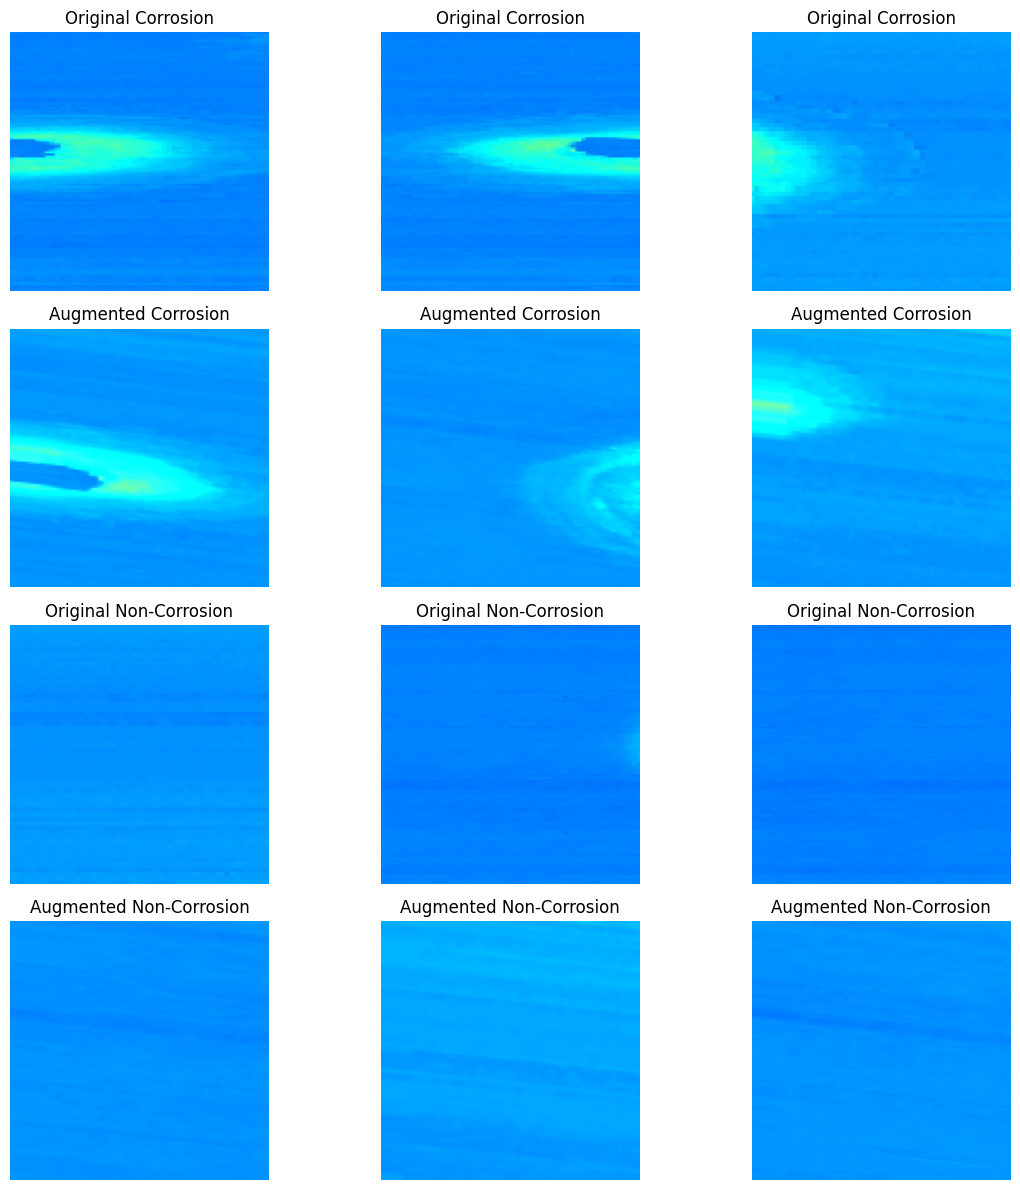

In [22]:
# Pastas
orig_corro_dir = "data/patches/originals/1_corrosion"
aug_corro_dir = "data/patches/augmented/1_corrosion"
orig_noncorro_dir = "data/patches/originals/0_non_corrosion"
aug_noncorro_dir = "data/patches/augmented/0_non_corrosion"

# Lendo imagens
imgs_orig_corro = read_random_images(orig_corro_dir, 3)
imgs_aug_corro = read_random_images(aug_corro_dir, 3)
imgs_orig_noncorro = read_random_images(orig_noncorro_dir, 3)
imgs_aug_noncorro = read_random_images(aug_noncorro_dir, 3)

# Plot
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for i, img in enumerate(imgs_orig_corro):
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Original Corrosion")

for i, img in enumerate(imgs_aug_corro):
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented Corrosion")

for i, img in enumerate(imgs_orig_noncorro):
    axes[2, i].imshow(img)
    axes[2, i].axis("off")
    axes[2, i].set_title("Original Non-Corrosion")

for i, img in enumerate(imgs_aug_noncorro):
    axes[3, i].imshow(img)
    axes[3, i].axis("off")
    axes[3, i].set_title("Augmented Non-Corrosion")

plt.tight_layout()
plt.show()



* Patches converted to 128x128 px formal
* Patches stored in folder, organized by class (Corrosion x Non Corrosion)
* Data Augmentation parameters created and tested.




#2 - Creating and training first CNN model

### Splitting the dataset into training and validation

In [23]:
# target train/val directories
base_dir = "data"
train_corro = os.path.join(base_dir, "train/1_corrosion")
train_non_corro = os.path.join(base_dir, "train/0_non_corrosion")
val_corro = os.path.join(base_dir, "val/1_corrosion")
val_non_corro = os.path.join(base_dir, "val/0_non_corrosion")

# create directories if not exist
for d in [train_corro, train_non_corro, val_corro, val_non_corro]:
    os.makedirs(d, exist_ok=True)

# Creating the function to split the patches into training and testing folders
test_percentage = 0.2 ## 20% of patches used to validate if the training was effective



# run for both classes
split_and_copy(orig_corro_dir, train_corro, val_corro, test_size=test_percentage)
split_and_copy(orig_noncorro_dir, train_non_corro, val_non_corro, test_size=test_percentage)

print("✅ Split done!")

📊 data/patches/originals/1_corrosion: 9 train, 3 val
📊 data/patches/originals/0_non_corrosion: 8 train, 3 val
✅ Split done!


### Using online data augmentation to generate more images for training and validation

Note that patch images occupy space in the hard disk memory. It is not needed to occupy space with augmented images, because we can create them on-the-fly, directly to be used by the learning process. So we will define this process now, just before the learning process starts.

In [24]:
# ===============================
# 1️⃣ Train generator
# ===============================
train_generator = train_datagen.flow_from_directory(
    directory='data/train',          # training folder
    target_size=IMG_SIZE,            # standard image sizes
    batch_size=32,
    class_mode='binary',             # 2 classes: non corrosion x corrosion
    subset='training',               # takes the training part (80%)
    shuffle=True,
    seed=SEED
)

# ===============================
# 2️⃣ Validation generator
# ===============================
val_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation',             # takes the validation part (20%)
    shuffle=False,
    seed=SEED
)

# Checking classes mapping
print(train_generator.class_indices)

Found 15 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
{'0_non_corrosion': 0, '1_corrosion': 1}


## Creating a simple CNN for binary classification

In [25]:
# =========================
# 1️⃣ Defining the Model
# =========================

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # saída binária
])

# =========================
# 2️⃣ Compiling the model
# =========================
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# =========================
# 3️⃣ Training the model
# =========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5333 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 1.1557
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5333 - loss: 0.8981 - val_accuracy: 0.5000 - val_loss: 0.6614
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5333 - loss: 0.7600 - val_accuracy: 1.0000 - val_loss: 0.6583
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - accuracy: 0.6667 - loss: 0.6273 - val_accuracy: 0.5000 - val_loss: 0.8248
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.5333 - loss: 0.7300 - val_accuracy: 0.5000 - val_loss: 0.6100
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - accuracy: 0.5333 - loss: 0.5893 - val_accuracy: 1.0000 - val_loss: 0.4431
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - accuracy: 0.8000 - loss: 0.5336 - val_accuracy: 1.0000 - val_loss: 0.4967
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.9333 - loss: 0.3811 - val_accuracy: 0.5000 - val_loss: 0.9112
E

**The CNN is created and trained!**

## Checking the model effectivess

This proces will run as follows:
- a sliding window function will be defined. This function iterates over the complete images, checking smaller pieces of images and assigning a probability of corrosion existing at that piece.
- the sliding windows function will be executed. Every time the model predicts corrosion, a small box will be drawn in the small piece being checked.
- at the end of the iteration, a bigger bounding box will be drawn, comprehending all the small boxes.
- the bounding box defined by the model's prediction will be compared to bounding box created by a human, specialist in corrosion detection. The comparison will calculate the IoU (Intersection over Union), which represents how close the 2 bounding boxes are from each other. 0 represents completely disjoint boxes, and 1 represents identical boxes (same size and same location).
- the average of the IoU for all images is a metric of quality of this model.

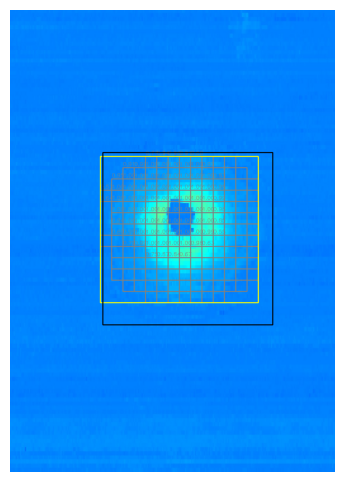

Metrics (all images): {'mean_iou': np.float64(0.7784257525756324), 'per_image': {'valid4.jpeg': {'mean_iou': np.float64(0.7673029628761829), 'min_iou': np.float64(0.7673029628761829), 'max_iou': np.float64(0.7673029628761829), 'num_patches': 87}, 'valid3.jpeg': {'mean_iou': np.float64(0.8115806021341366), 'min_iou': np.float64(0.8115806021341366), 'max_iou': np.float64(0.8115806021341366), 'num_patches': 393}, 'valid5.jpeg': {'mean_iou': np.float64(0.7350050150451178), 'min_iou': np.float64(0.7350050150451178), 'max_iou': np.float64(0.7350050150451178), 'num_patches': 171}, 'valid1.jpeg': {'mean_iou': np.float64(0.8549185586654894), 'min_iou': np.float64(0.8549185586654894), 'max_iou': np.float64(0.8549185586654894), 'num_patches': 95}, 'valid2.jpeg': {'mean_iou': np.float64(0.723321624157235), 'min_iou': np.float64(0.723321624157235), 'max_iou': np.float64(0.723321624157235), 'num_patches': 110}}}


In [27]:
# 1) Run with plot=True for a single image (visual inspection)
summary_single = evaluate_sliding_window(
    model=model,
    validation_dir="CorrosionDetection/Screenshots UTWM/validation_images",
    annotations_dir="CorrosionDetection/Screenshots UTWM/validation_images_annotations",
    patch_size=(128,128),
    stride=32,
    threshold=0.5,
    plot=True,
    max_plot_images=1
)

print("Metrics (all images):", summary_single)


In [28]:
original_CNN_IoU = summary_single["mean_iou"]
print("The overall IoU of this model is ", summary_single["mean_iou"])

The overall IoU of this model is  0.7784257525756324


#3 - Creating and training new CNNs

Let's create a function to define new CNNs following parameters specified when the function is called:

Now creating the CNNs:

In [29]:
# --------------------------
# CNN configurations
# --------------------------
cnn_configs = {
    "CNN_0": {"filters":[32,64,128], "dropout":0.5},      # original model
    "CNN_1": {"filters":[16,32,64],  "dropout":0.3},      # lighter model
    "CNN_2": {"filters":[32,64,128], "dropout":0.5},      # control model
    "CNN_3": {"filters":[64,128,256],"dropout":0.5},      # larger model
    "CNN_4": {"filters":[32,64,128,128],"dropout":0.3},   # deeper model
    "CNN_5": {"filters":[32,64,128], "dropout":0.7}       # higher regularization
}

# --------------------------
# Create CNN models
# --------------------------
cnn_models = {}
for name, cfg in cnn_configs.items():
    cnn_models[name] = build_cnn(cfg["filters"], cfg["dropout"])

# --------------------------
# Print summary of models
# --------------------------
print("CNNs successfully created:")
for name, cfg in cnn_configs.items():
    print(f"{name}: {len(cfg['filters'])} convolutional layers, dropout={cfg['dropout']}")

CNNs successfully created:
CNN_0: 3 convolutional layers, dropout=0.5
CNN_1: 3 convolutional layers, dropout=0.3
CNN_2: 3 convolutional layers, dropout=0.5
CNN_3: 3 convolutional layers, dropout=0.5
CNN_4: 4 convolutional layers, dropout=0.3
CNN_5: 3 convolutional layers, dropout=0.7


Explanation of CNN variations:

CNN_0 (original): 3 convolutional layers (32→64→128 filters) with MaxPooling, Dense(128) and Dropout(0.5). Serves as the baseline for comparison.

CNN_1: fewer filters (16→32→64) and smaller dropout (0.3). This lighter network trains faster, is less prone to overfitting, but has lower capacity to capture complex patterns.

CNN_2: identical to the original (32→64→128 filters, dropout 0.5). Serves as a control model for experimental comparison.

CNN_3: more filters (64→128→256). Higher capacity, can capture more complex patterns, but increased risk of overfitting and longer training time.

CNN_4: deeper network with 4 convolutional layers (32→64→128→128) and smaller dropout (0.3). Greater depth allows learning more complex features, while smaller dropout helps retain capacity.

CNN_5: same as original but with larger dropout (0.7). Stronger regularization to reduce overfitting, useful for small datasets, at the cost of potentially slower convergence or slightly lower accuracy.

Now Let's train these models:

In [30]:

# ===============================
# Train all CNN models
# ===============================
histories = {}

for name, model in cnn_models.items():
    histories[name] = train_model(model, name, train_generator, val_generator, epochs=20)

print("🎉 All CNN models have been trained successfully!")



🎯 Training CNN_0...

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6000 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 1.0126
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 0.4667 - loss: 1.0602 - val_accuracy: 0.5000 - val_loss: 0.7286
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - accuracy: 0.5333 - loss: 0.7960 - val_accuracy: 0.5000 - val_loss: 0.6381
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.3333 - loss: 0.7544 - val_accuracy: 0.5000 - val_loss: 0.8560
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - accuracy: 0.5333 - loss: 0.6173 - val_accuracy: 0.5000 - val_loss: 0.6289
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.5333 - loss: 0.6238 - val_accuracy: 0.5000 - val_loss: 0.6076
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.6000 - loss: 0.5976 - val_accuracy: 0.5000 - val_loss: 0.5016
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - accuracy: 0.7333 - loss: 0.5278 - val_accuracy:

All models created, let's compare them.

#4 - Evaluating and comparing the effectiveness of different CNNs

In [31]:
# ===============================
# Evaluate all CNN models using sliding window
# ===============================
results_summary = {}

for name, model in cnn_models.items():
    print(f"\n🔍 Evaluating {name} with sliding window...\n")
    summary = evaluate_sliding_window(
        model,
        validation_dir="CorrosionDetection/Screenshots UTWM/validation_images",
        annotations_dir="CorrosionDetection/Screenshots UTWM/validation_images_annotations",
        patch_size=(128,128),
        stride=32,
        threshold=0.5,
        plot=False
    )
    results_summary[name] = summary

print("🎉 All CNN models have been evaluated successfully!")



🔍 Evaluating CNN_0 with sliding window...


🔍 Evaluating CNN_1 with sliding window...


🔍 Evaluating CNN_2 with sliding window...


🔍 Evaluating CNN_3 with sliding window...


🔍 Evaluating CNN_4 with sliding window...


🔍 Evaluating CNN_5 with sliding window...

🎉 All CNN models have been evaluated successfully!


In [32]:
# ===============================
# Build a DataFrame with metrics
# ===============================
df_rows = []

for name, summary in results_summary.items():
    per_image = summary["per_image"]

    mean_ious = [v["mean_iou"] for v in per_image.values()]
    patches   = [v["num_patches"] for v in per_image.values()]

    df_rows.append({
        "Model": name,
        "Global Mean IoU": np.mean(mean_ious),
        "Std IoU": np.std(mean_ious),
        "Num Images": len(per_image),
        "Total Patches": np.sum(patches)
    })

df_results = pd.DataFrame(df_rows)
print("📊 Evaluation Summary Across Models:")
print(df_results)


📊 Evaluation Summary Across Models:
   Model  Global Mean IoU   Std IoU  Num Images  Total Patches
0  CNN_0         0.672369  0.086300           5           1029
1  CNN_1         0.649246  0.209175           5           1571
2  CNN_2         0.682466  0.135291           5           1396
3  CNN_3         0.663833  0.136268           5           1227
4  CNN_4         0.782505  0.059363           5            834
5  CNN_5         0.763624  0.043108           5            762


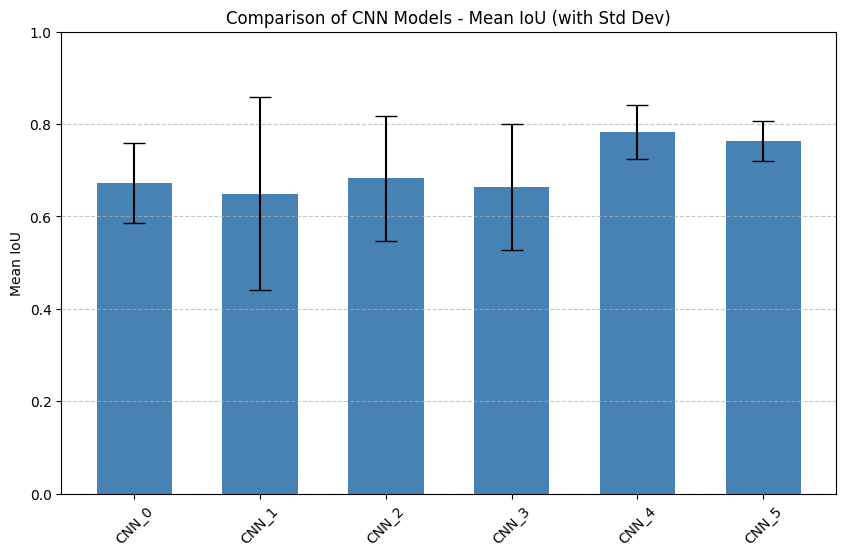

In [33]:
# ===============================
# Aggregate Mean IoU and Std IoU
# ===============================
mean_metrics = {}
std_metrics = {}

for name, summary in results_summary.items():
    per_image = summary["per_image"]
    mean_ious = [v["mean_iou"] for v in per_image.values()]
    mean_metrics[name] = np.mean(mean_ious)
    std_metrics[name] = np.std(mean_ious)

# Convert to lists for plotting
models = list(mean_metrics.keys())
mean_vals = [mean_metrics[m] for m in models]
std_vals  = [std_metrics[m] for m in models]

x = np.arange(len(models))

# ===============================
# Plot (Mean IoU + Std as error bar)
# ===============================
plt.figure(figsize=(10,6))
plt.bar(x, mean_vals, width=0.6, color="steelblue", yerr=std_vals, capsize=8)

plt.xticks(x, models, rotation=45)
plt.ylabel("Mean IoU")
plt.title("Comparison of CNN Models - Mean IoU (with Std Dev)")
plt.ylim(0, 1)  # IoU always in [0,1]
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


#5 - Conclusion, Lessons learnt and Next Steps

### Conclusions
As we've seen, it has been possible to create 6 CNN and train them to recognize, in the provided images, the patterns that correspond to corrosion in images representing UT data. Using this, the CNNs were able to "identify" the "corrosion anomalies" in the provided data. Indeed, the 6 models were able to detect the corrosion spot in every image used as test, with variances how precise the predicted bounding box matches to the annotated bounding box.

The creation of these CNNs were easy with a function that builds CNNs based on given parameters, like shape and dropout ratio. In fact, we could easily create much more CNNs with different configurations.

The different CNNs have different performances regarding IoU (Intersection over Union), the chosen metric. Anyhow even the worst IoU was able to spot the corrosion, although with many "false calls" - false positives. This is already an exciting and promising result. On the other hand, the best IoU performed great!

#### Function to plot best and worst IoU

Best IoU: 0.870 -> Model: CNN_1, Image: valid4.jpeg
Worst IoU: 0.286 -> Model: CNN_1, Image: valid1.jpeg


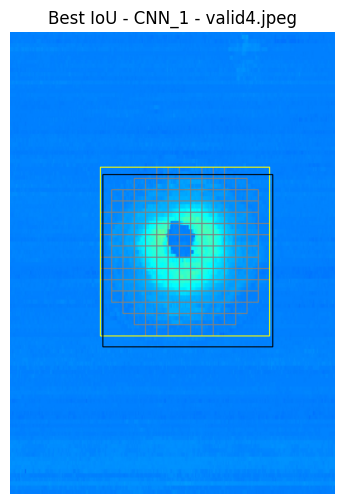

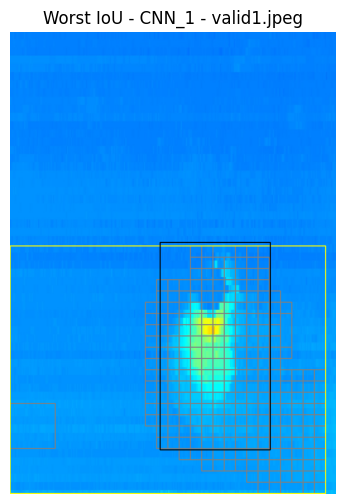

In [34]:
plot_best_worst_iou(
    results_summary,
    cnn_models,
    validation_dir="CorrosionDetection/Screenshots UTWM/validation_images",
    annotations_dir="CorrosionDetection/Screenshots UTWM/validation_images_annotations",
    patch_size=(128,128),
    stride=32,
    threshold=0.5
)


### Lessons Learnt
One point that took our attention is the fact that CNN_0 and CNN_2 have the same architecture, but very different results. We created CNN_2 exactly to spot this, as a control. Despite I have used SEED in the random functions to provide consistency, the results vary. I suspect that some part of the algorithm is not controlled by seed.

Having the CNN_0 and CNN_2 the same architecture but different results, we can't conclude that the differences in performance among all the CNNs are due to the architecture, being possibly due to the uncontrolled randomness.

### Next Steps


Having this MVP being able to create CNNs that spot the corrosion pattern in images, we can suggest the following ways to keep evolving toward a commercially acceptable solution:


*   Control the randomness - an alternative is to run the training / evaluation cycle multiple times, to reduce variance. Having this we can evaluate the best CNN model.
*   Provide more images in the training phase, making the model able to identify not only the corrosion, but also signals, as weldings and roughness.
*   We can implement advanced models as Yolo, training it to spot corrosion, welds etc in imagens.
*   On the other hand, ss the images are actually a graphical representation of the measurements collected by the sensors, we can develop CNNs based in the raw numerical data, not the images.



### **Last note**: many thanks to the colleagues who shared screenshots of the UT data.